# Analysing Router Logs

We will first import necessary libraries

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random

# changing style
plt.style.use('default')
plt.rcParams["font.family"] = "Jetbrains Mono"

## Strategy

1. We will try and simluate a few attacks on a router, and check whether those attacks can be detected in hindsight.
2. To do that we will start with generating some demo data for a router, inspired by my home router. This will be a monitor of active DHCP Clients. 
3. We will then try and analyse the data to find out anomalies in normal usage. 

# Generating _normal_ demo data

In [184]:
# columns
data = {
    'MAC' : [],
    'IP Address': [],
    'Device Name': [],
    'Interface': [],
    'Requested IP': [],
    'Time': []
}

In [185]:
# Creating a pandas dataframe

normal_log_db = pd.DataFrame(data)
normal_log_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time


In [276]:
# Writing functions for columns that we wanna generate randomly
def generate_mac_address():
    mac = [random.randint(0x00, 0xff) for i in range(6)]
    return ':'.join(map(lambda x: "%02x" % x, mac))


def generate_dest_ip_address():
    # define the weights for each website
    website_weights = {'Youtube': 15, 'Instagram': 10, 'Facebook': 8, 'Twitter': 5, 'Other': 2}
    
    # create a list of websites based on their weights
    websites = []
    for website, weight in website_weights.items():
        websites.extend([website] * weight)
    
    # randomly select a website from the list
    website = random.choice(websites)
    
    # generate a random IP address for the website
    if website == 'Youtube':
        return ('216.58.194.45' , website)
    elif website == 'Instagram':
        return ('3.213.31.34' , website)
    elif website == 'Facebook':
        return ('69.63.176.22' , website)
    elif website == 'Twitter':
        return ('104.244.42.12' , website)
    else:
        return ('192.168.1.53' , website)

def generate_device_ip_address():
    ip = '192.168.1.' + str(random.randint(0, 255))
    return ip

def generate_device_name():
    device_names = ['iPhone', 'Samsung', 'OnePlus', 'Nokia', 'Xiaomi', 'Oppo', 'Vivo', 'Realme', 'Micromax', 'Lenovo']
    return random.choice(device_names)

def generate_interface(): 
    interfaces = ['5gz', '2.4gz']
    return random.choice(interfaces)

def generate_date_time():
    # generate random date and time, but only in the range of a few days
    start_date = pd.to_datetime('2023-01-01')
    
    # generate random number of days
    days_to_add = random.randint(0, 10)
    
    # generate random number of seconds
    seconds_to_add = random.randint(0, 86400)
    
    # add random days and seconds to start date
    end_date = start_date + pd.Timedelta(days=days_to_add, seconds=seconds_to_add)
    
    # set the hour of the timestamp based on the time of day
    hour = end_date.hour
    if hour < 6:
        # almost no traffic between 2am and 6am
        hour = random.randint(6, 23)
    elif hour < 9:
        # more traffic during the morning hours
        hour = random.randint(6, 10)
    elif hour < 18:
        # most traffic during the daytime
        hour = random.randint(9, 17)
    else:
        # less traffic during the evening hours
        hour = random.randint(17, 23)
    
    # set the hour of the timestamp
    end_date = end_date.replace(hour=hour)
    
    # return timestamp as string
    return end_date.strftime('%Y-%m-%d %H:%M:%S')

def gen_protocols():
    protocols = ['TCP', 'UDP', 'DHCP', 'HTTP', 'HTTPS', 'FTP', 'SMTP', 'POP3', 'IMAP', 'DNS', 'ICMP']
    weights = [0.3, 0.2, 0.1, 0.15, 0.1, 0.05, 0.05, 0.025, 0.025, 0.025, 0.030]
    return random.choices(protocols, weights=weights)[0]

In [283]:
# Generate normal data, consider a home environment. with 10 users. across a span of 10 days. Visiting 100 websites per device per day. 

normal_log_db = pd.DataFrame(columns=['MAC', 'IP Address', 'Device Name', 'Interface', 'Requested IP', 'Time'])

for i in range(10):
    temp_df = pd.DataFrame({
        'MAC' : [generate_mac_address() for j in range(100)],
        'IP Address': [generate_device_ip_address() for j in range(100)],
        'Device Name': [generate_device_name() for j in range(100)],
        'Interface': [generate_interface() for j in range(100)],
        'Requested IP': [generate_dest_ip_address()[0] for j in range(100)],
        'Requested Website': [generate_dest_ip_address()[1] for j in range(100)],
        'Protocol': [gen_protocols() for j in range(100)],
        'Time': [generate_date_time() for j in range(100)]
    })
    
    normal_log_db = pd.concat([normal_log_db, temp_df], ignore_index=True)

normal_log_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time,Requested Website,Protocol
0,d1:c3:0e:b1:4a:2a,192.168.1.10,Samsung,5gz,104.244.42.12,2023-01-08 16:52:09,Instagram,HTTP
1,e8:17:4f:5f:68:d4,192.168.1.69,Realme,2.4gz,69.63.176.22,2023-01-10 16:57:28,Instagram,TCP
2,36:da:ad:5f:c8:e7,192.168.1.206,OnePlus,5gz,104.244.42.12,2023-01-03 18:16:09,Facebook,HTTP
3,56:40:7b:a1:af:e5,192.168.1.225,Vivo,5gz,216.58.194.45,2023-01-09 16:56:05,Instagram,HTTP
4,79:d3:f8:5c:43:c0,192.168.1.147,OnePlus,2.4gz,69.63.176.22,2023-01-09 16:18:09,Facebook,ICMP
...,...,...,...,...,...,...,...,...
995,65:1a:e2:19:ce:a1,192.168.1.27,Lenovo,5gz,69.63.176.22,2023-01-06 18:37:00,Youtube,TCP
996,e3:37:4c:e0:5e:72,192.168.1.59,Xiaomi,2.4gz,3.213.31.34,2023-01-11 23:05:35,Youtube,SMTP
997,f9:4b:a3:61:8d:b9,192.168.1.206,Samsung,2.4gz,104.244.42.12,2023-01-02 16:36:47,Youtube,UDP
998,43:5e:7a:35:55:60,192.168.1.48,Oppo,2.4gz,104.244.42.12,2023-01-04 19:29:21,Instagram,UDP


In [284]:
# now sort data by time
normal_log_db = normal_log_db.sort_values(by=['Time'])
normal_log_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time,Requested Website,Protocol
94,fd:ac:25:ff:df:e4,192.168.1.116,Micromax,2.4gz,69.63.176.22,2023-01-01 06:02:02,Youtube,UDP
557,06:8b:a0:e1:7f:5b,192.168.1.211,Oppo,2.4gz,216.58.194.45,2023-01-01 06:04:08,Other,DHCP
47,a8:aa:dc:1d:da:17,192.168.1.116,Realme,5gz,3.213.31.34,2023-01-01 06:04:40,Facebook,TCP
277,7e:38:96:09:7c:2f,192.168.1.146,Samsung,5gz,104.244.42.12,2023-01-01 06:49:23,Other,SMTP
828,51:8f:d1:10:5a:d8,192.168.1.187,Micromax,2.4gz,216.58.194.45,2023-01-01 06:58:15,Youtube,HTTP
...,...,...,...,...,...,...,...,...
996,e3:37:4c:e0:5e:72,192.168.1.59,Xiaomi,2.4gz,3.213.31.34,2023-01-11 23:05:35,Youtube,SMTP
935,e1:1e:dd:d8:c3:f5,192.168.1.252,Oppo,2.4gz,216.58.194.45,2023-01-11 23:14:33,Youtube,HTTPS
917,b5:5c:b4:99:eb:60,192.168.1.247,Oppo,2.4gz,69.63.176.22,2023-01-11 23:21:28,Instagram,UDP
286,ec:1c:b6:ae:aa:32,192.168.1.195,Nokia,2.4gz,104.244.42.12,2023-01-11 23:54:54,Youtube,TCP


/tmp/ipykernel_1253999/2572816055.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(dates.index, dates.values, color='purple', marker='o', linestyle='dashed', linewidth=1, markersize=5)


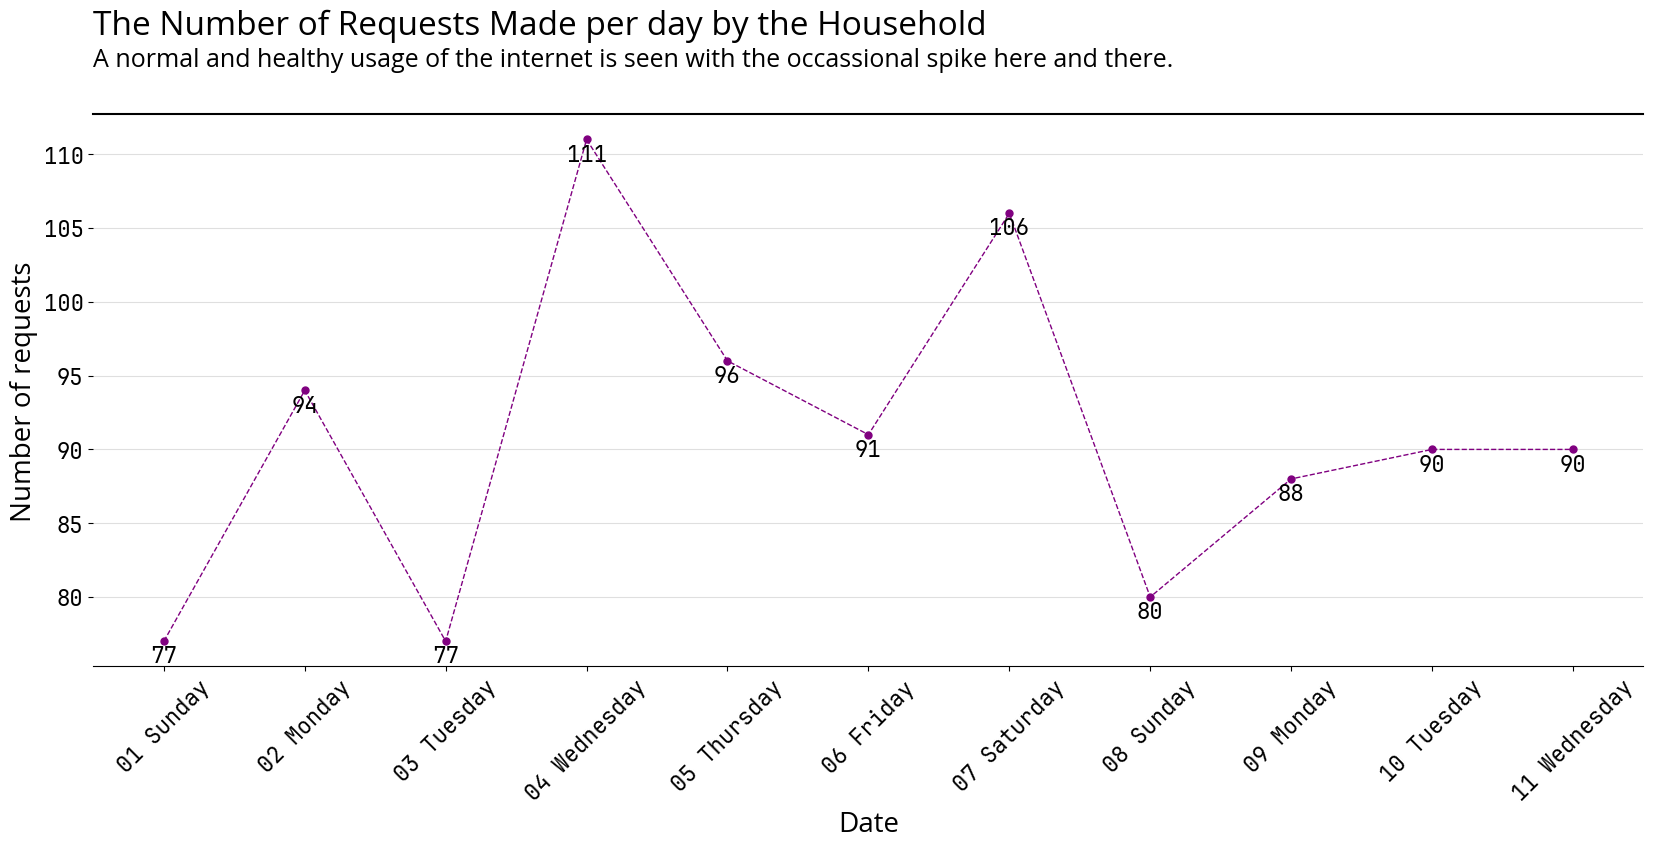

In [288]:
# let us plot the number of requests per day
normal_log_db['Time'] = pd.to_datetime(normal_log_db['Time'])
normal_log_db['Date'] = normal_log_db['Time'].dt.date 

# sort data by date
normal_log_db = normal_log_db.sort_values(by=['Date'])

normal_log_db.head()

# now let us plot the number of requests per day
dates = normal_log_db['Date'].value_counts()

# sorting dates
dates = dates.sort_index()

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'The Number of Requests Made per day by the Household'
subtitle = 'A normal and healthy usage of the internet is seen with the occassional spike here and there. '

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)

plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# plotting as a time series
plt.plot_date(dates.index, dates.values, color='purple', marker='o', linestyle='dashed', linewidth=1, markersize=5)

# also put labels on the markers a little over the markers for visibility
for i in range(len(dates)):
    plt.text(dates.index[i], dates.values[i]-1, dates.values[i], ha='center', va='center', color='black', fontsize=16)
    
# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Date', fontsize=20, fontname="Open Sans")
plt.ylabel('Number of requests', fontsize=20, fontname="Open Sans")

# change space on top of chart we are actually adjusting the scale of the plot as well. 
plt.subplots_adjust(top=0.8, wspace=0.3)

# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# tilt the x-axis labels by 45 degrees
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.4)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# customize the tick labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %A'))

plt.show()

<BarContainer object of 10 artists>

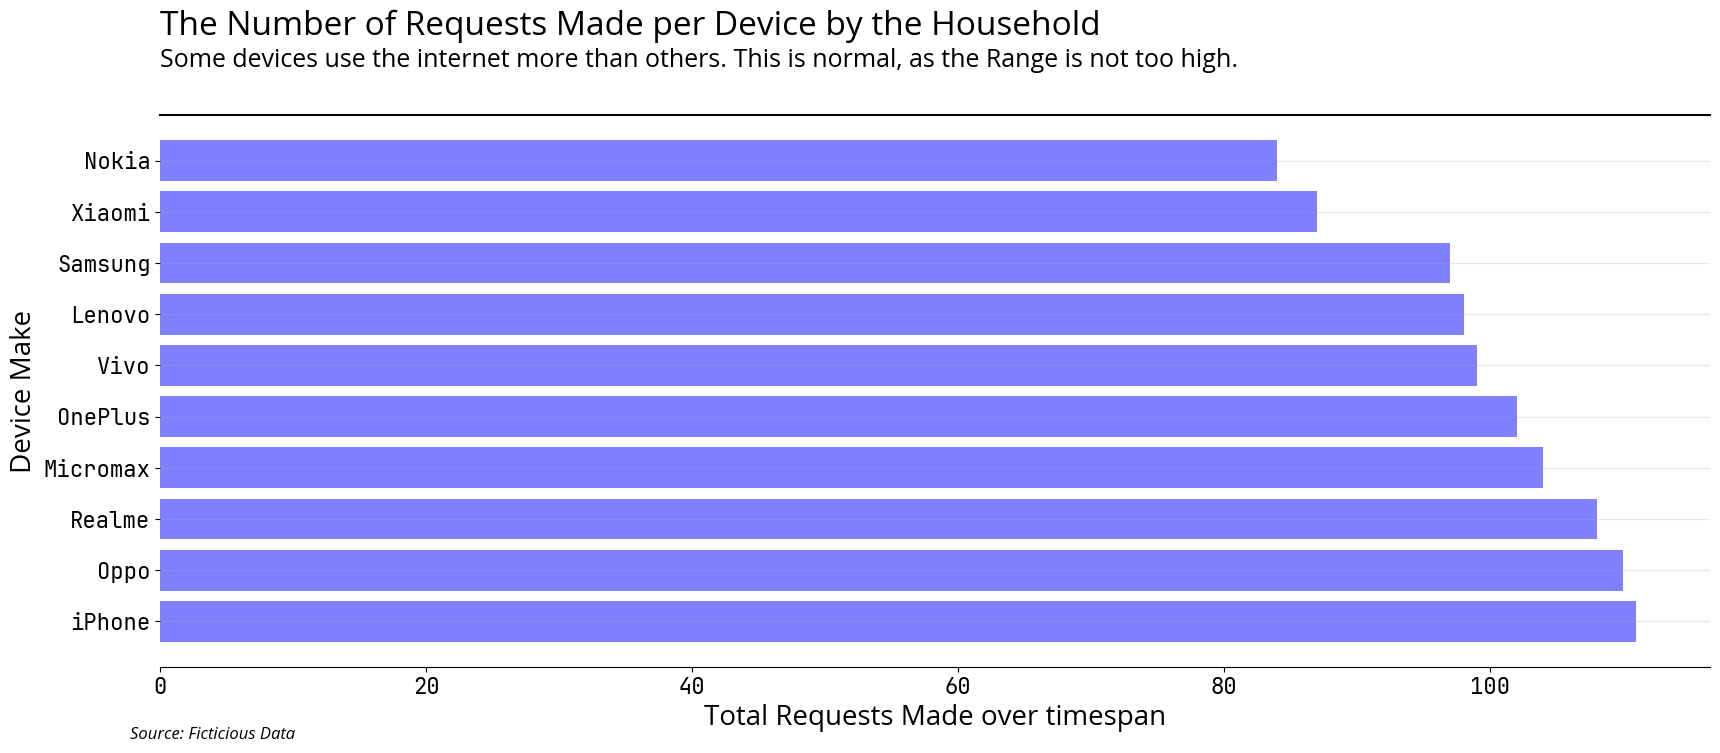

In [289]:
# let us now plot the number of requests per device

devices = normal_log_db['Device Name'].value_counts()

# sorting devices in descending order
devices = devices.sort_values(ascending=False)

# plotting

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'The Number of Requests Made per Device by the Household'
subtitle = 'Some devices use the internet more than others. This is normal, as the Range is not too high.'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.3)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)


# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans")
plt.ylabel('Device Make', fontsize=20, fontname="Open Sans")


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# foot note
footnote = "Source: Ficticious Data"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

plt.barh(devices.index, devices.values, color='blue', alpha=0.5)


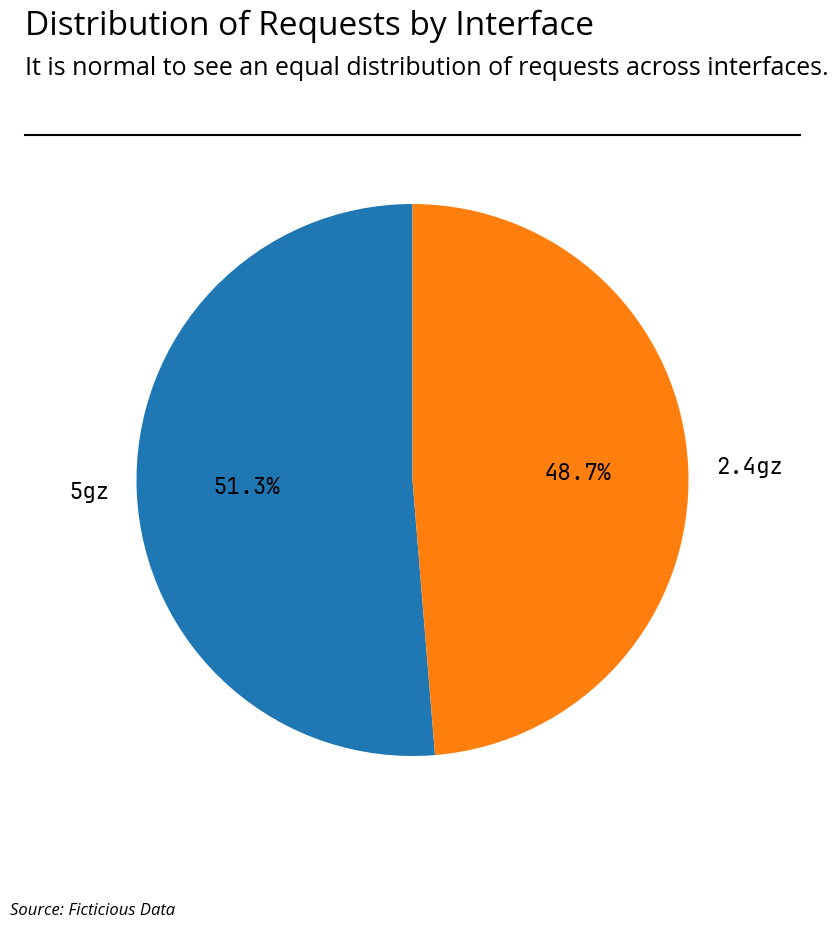

In [290]:
import matplotlib.pyplot as plt

# assuming you have a DataFrame called `normal_log_db` with a column called 'Interface'
interface_counts = normal_log_db['Interface'].value_counts()

# creating the plot. 
fig, ax = plt.subplots(figsize=(10, 10))

# informative title + subtitle
title = 'Distribution of Requests by Interface'
subtitle = 'It is normal to see an equal distribution of requests across interfaces.'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# set the font size of the labels
plt.rcParams['font.size'] = 16

# Create a pie chart to show the distribution of requests per interface
plt.pie(interface_counts.values, labels=interface_counts.index, autopct='%1.1f%%', startangle=90)


# foot note
footnote = "Source: Ficticious Data"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

# display the plot
plt.show()

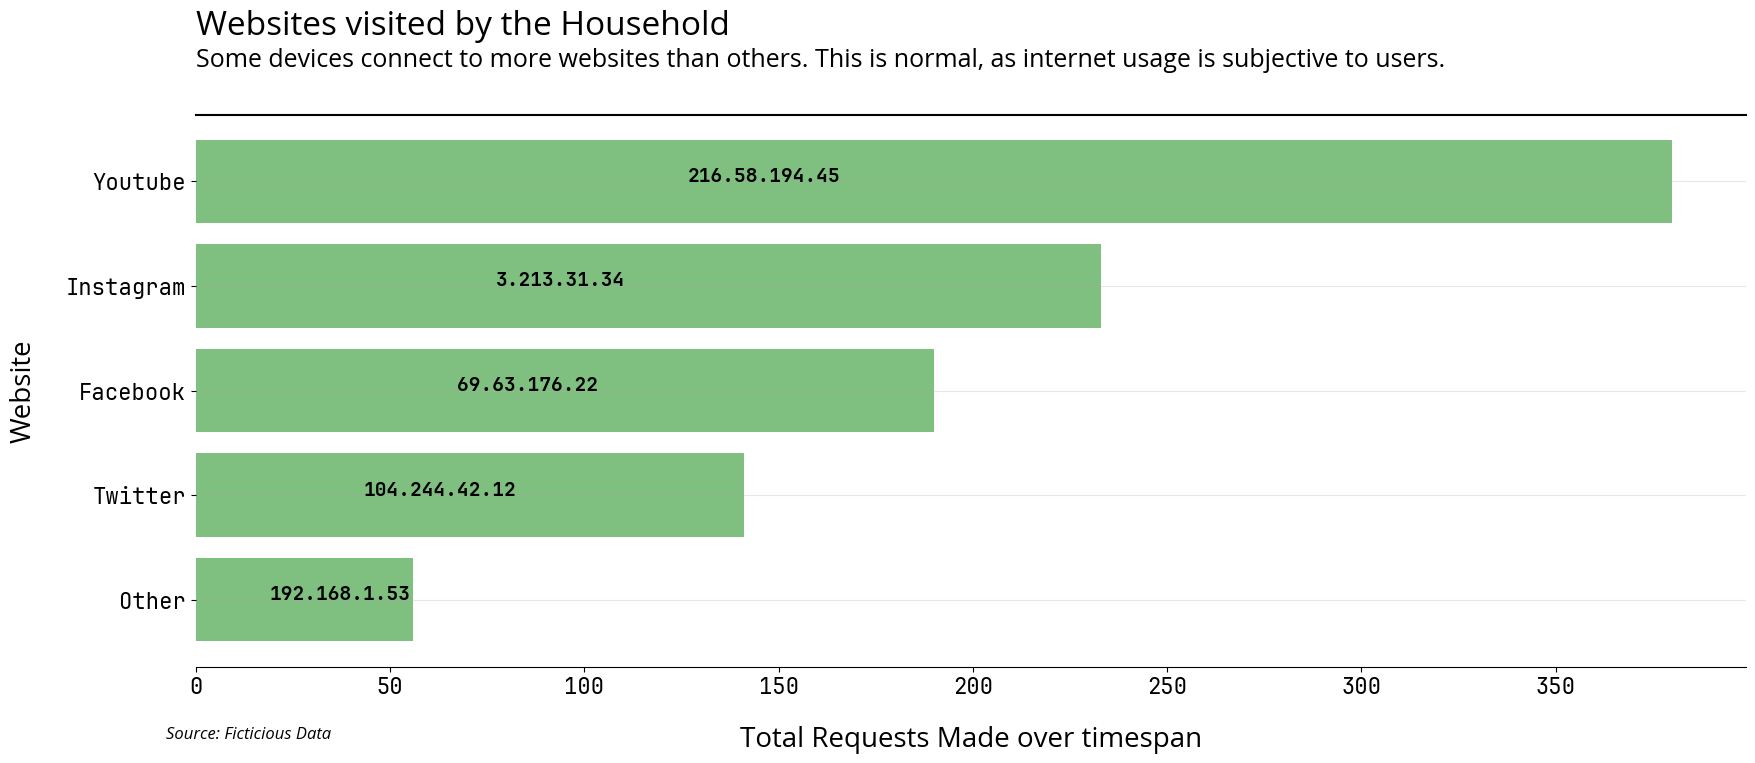

In [291]:
import matplotlib.pyplot as plt

# assuming you have a DataFrame called `normal_log_db` with columns called 'Requested IP' and 'Requested Website'
destination_ips = normal_log_db['Requested IP'].value_counts()
destination_ips = destination_ips.sort_values(ascending=False)

destination_websites = normal_log_db['Requested Website'].value_counts()
destination_websites = destination_websites.sort_values(ascending=False)

destination_ips = destination_ips.iloc[::-1]
destination_websites = destination_websites.iloc[::-1]

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Websites visited by the Household'
subtitle = 'Some devices connect to more websites than others. This is normal, as internet usage is subjective to users. '

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.3)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)


# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# set the y-axis tick labels to the website names
plt.yticks(range(len(destination_websites)), destination_websites.index)

# invert the y-axis so that the website names are displayed from top to bottom
# plt.gca().invert_yaxis()

# add the names of the websites inside their individual bars
for i, v in enumerate(destination_ips.index):
    plt.text(x=destination_ips.values[i] / 3, y=i, s=v, color='black', fontweight='bold', fontsize=14)


# foot note
footnote = "Source: Ficticious Data"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

plt.barh(range(len(destination_websites)), destination_websites.values, color='green', alpha=0.5)


plt.show()

Text(0.11, 0.02, 'Source: Ficticious Data')

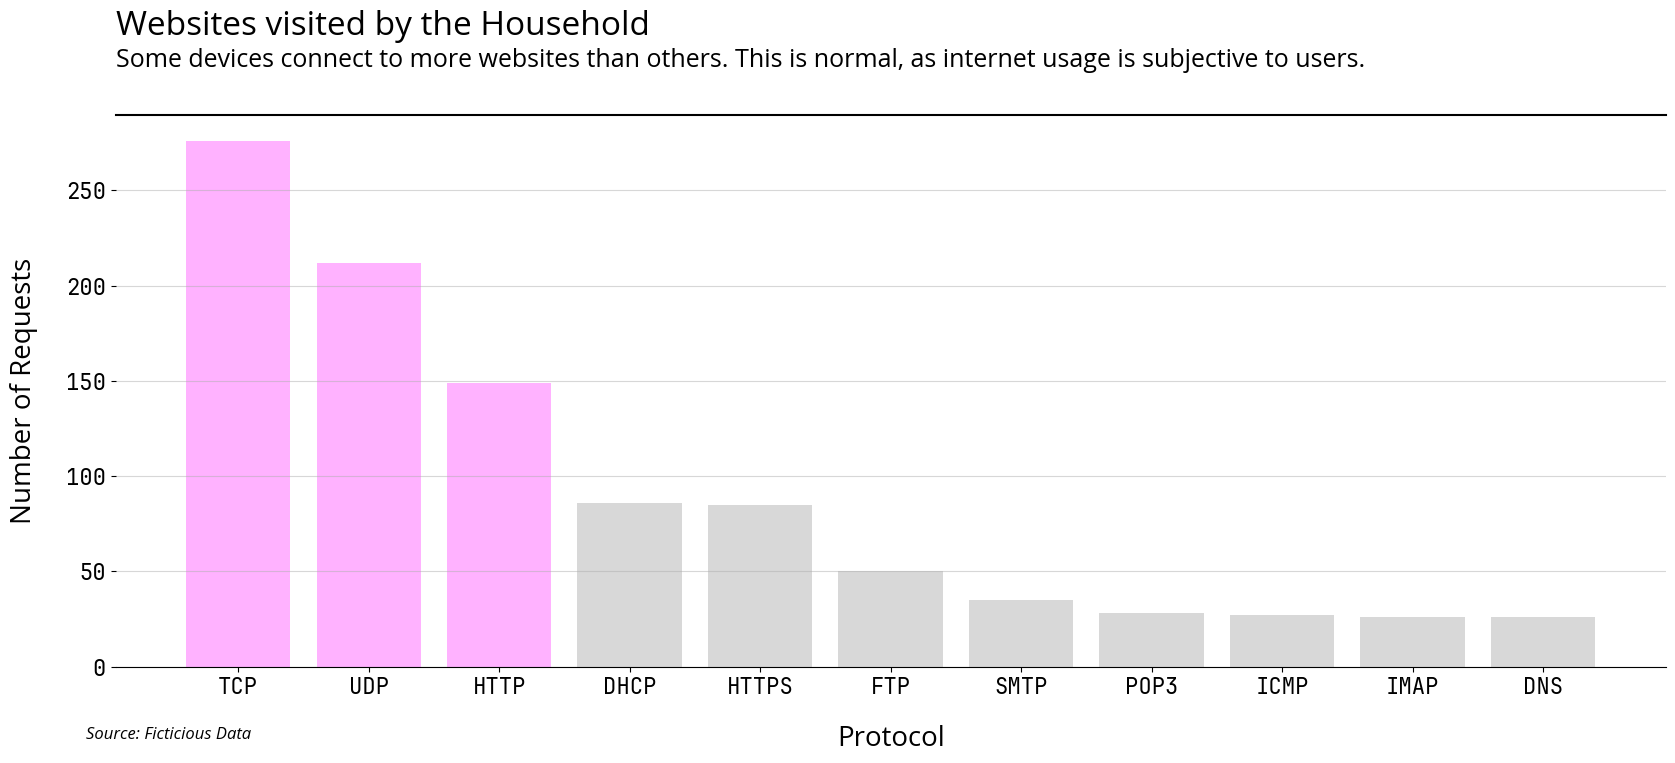

In [292]:
# let us now plot what protocols were used to make requests
# count the number of requests for each protocol

protocol_counts = normal_log_db['Protocol'].value_counts()

# set the color of the first rectangle to pink and the color of the other rectangles to gray
colors = ['magenta'] * 3 + ['gray'] * (len(protocol_counts) - 3)

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Websites visited by the Household'
subtitle = 'Some devices connect to more websites than others. This is normal, as internet usage is subjective to users. '

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.5)
# plt.grid(axis='x', alpha=0.5)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

plt.bar(protocol_counts.index, protocol_counts.values, color=colors, alpha=0.3)

# set the title and axis labels
# ax.set_title('Protocols Used to Make Requests')
ax.set_xlabel('Protocol')
ax.set_ylabel('Number of Requests')

# set the x-axis tick labels to be rotated for better readability
# plt.xticks(rotation=45)


# foot note
footnote = "Source: Ficticious Data"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)


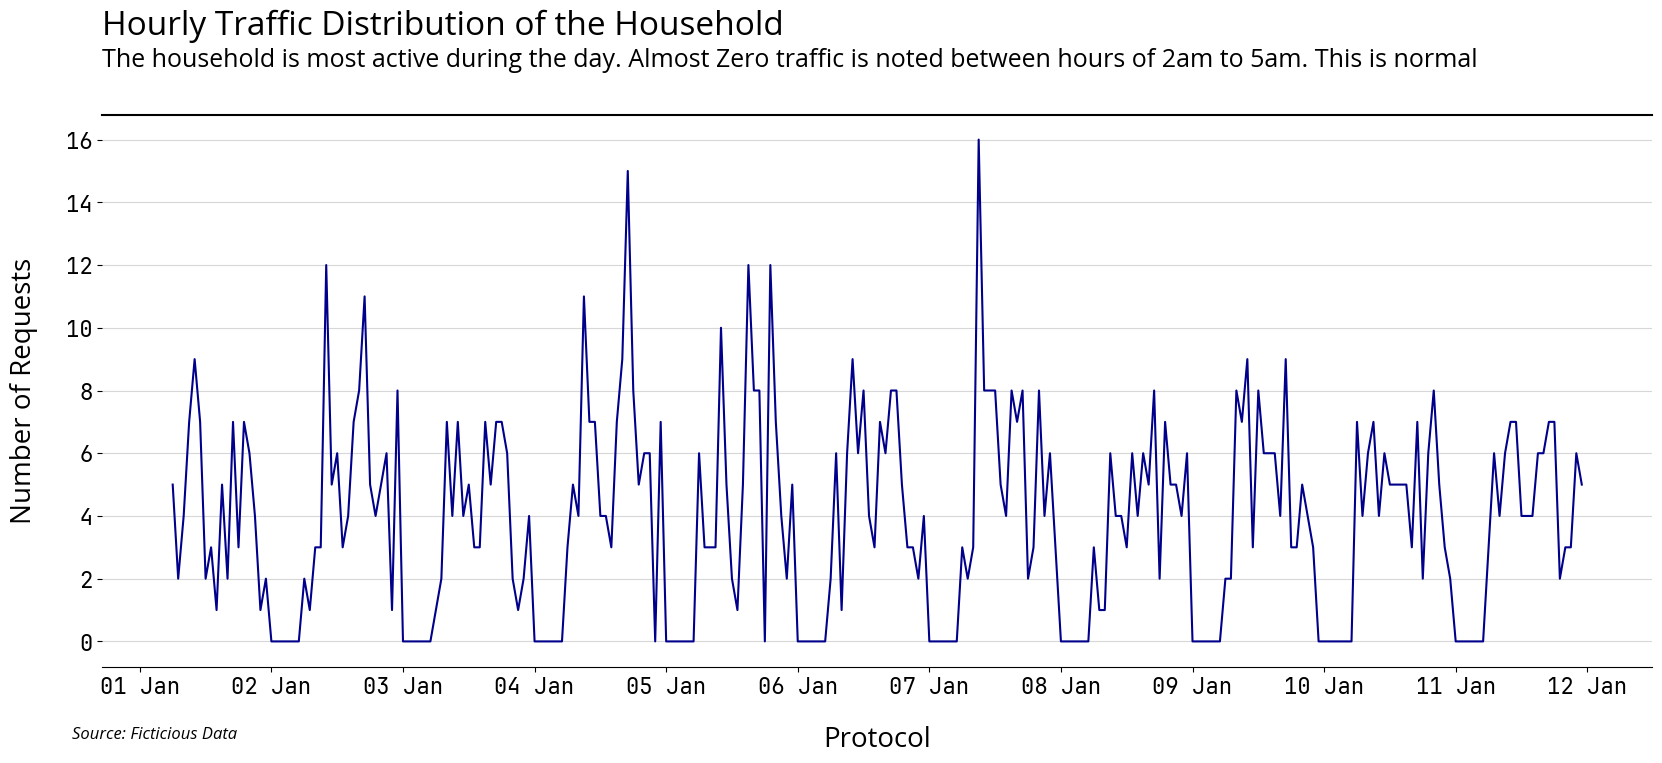

In [296]:
import matplotlib.pyplot as plt
import pandas as pd

temp_df = normal_log_db.copy()
# convert the 'Time' column to a datetime object
temp_df['Time'] = pd.to_datetime(temp_df['Time'])

# set the 'Time' column as the index
temp_df.set_index('Time', inplace=True)

# resample the data by hour and count the number of requests
hourly_counts = temp_df.resample('H').count()['MAC']


# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Hourly Traffic Distribution of the Household'
subtitle = 'The household is most active during the day. Almost Zero traffic is noted between hours of 2am to 5am. This is normal'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.5)
# plt.grid(axis='x', alpha=0.5)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# ax.set_title('Protocols Used to Make Requests')
ax.set_xlabel('Protocol')
ax.set_ylabel('Number of Requests')

# set the x-axis tick labels to be rotated for better readability
# plt.xticks(rotation=45)

plt.plot(hourly_counts.index, hourly_counts.values, color='darkblue')

# foot note
footnote = "Source: Ficticious Data"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

# customize the tick labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))



# Let us now simulate some attacks

# DDOS Attack